In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
team = False

In [3]:
if team:
    goldstandard="team"
    sheet=1
else:
    goldstandard="anna+philipp"
    sheet=0

In [4]:
from pici.pici import Pici
from pici.communities.oem import OEMCommunityFactory
from pici.communities.osm import OSMCommunityFactory
from pici.communities.preciousplastic import PPCommunityFactory
import pandas as pd

from pici.labelling import InnovationLabels
import seaborn as sns


import plotly.express as ex

Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer', 'graph_tool', 'karateclub', 'infomap'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'karateclub', 'ASLPAw'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'wurlitzer', 'infomap'}


In [5]:
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
pd.options.plotting.backend = "plotly"
plt.rcParams['figure.dpi'] = 200
sns.set(font="Corbel")
piPalette = sns.light_palette("#00769a", as_cmap=True)
piPalette2 = sns.light_palette("#f17d32", as_cmap=True)
colors = ['#f17d32','#00769a']
piPaletteCat = sns.set_palette(sns.color_palette(colors))

In [7]:
def plot_metrics(ira, metrics=['% complete agreement','Krippendorff alpha'], no_labels=False, show_n=True, legend=True, title=None, by_community=False):
    id_vars = ['index']
    if by_community:
        id_vars += ['community']
    d = ira.reset_index()[metrics + id_vars]
    d = d.melt(id_vars=id_vars,value_vars=metrics)
    if by_community:
        d.columns = ['label','community', 'metric','value']
    else:
        d.columns = ['label','metric','value']
    d['label'] = d.label.str.replace('label_','')
    d = d[~d['label'].isin(['any_activity','has_potential'])]
    plot_settings = {
        'x': 'label',
        'y': 'value',
        'hue': 'metric',
        'data': d,
        'palette': piPaletteCat
    }
    if no_labels:
        plot_settings['x'] = 'metric'
    if by_community:
        plot_settings['hue'] = 'community'
        # plot_settings['col'] = 'metric'
    fig = sns.barplot(**plot_settings)
    fig.set(ylim=(0,1))
    if show_n:
        if title is None:
            title = ""
        title += f' (n={int(ira["base n"].min())} to {int(ira["base n"].max())})'
    if not legend:
        fig.get_legend().remove()
    if title is not None:
        fig.set(title=title)

    fig.tick_params(axis='x', which='major', labelsize=8)

    return fig

In [8]:
pici = Pici(
    communities={
        'OpenEnergyMonitor': OEMCommunityFactory,
        'OpenStreetMap': OSMCommunityFactory,
        'PreciousPlastic': PPCommunityFactory,
    },
    labels=[
        InnovationLabels(
            pd.read_excel("../test_integrated_labels.xlsx", sheet_name=sheet),
        ),
        InnovationLabels().from_limesurvey(
            pd.read_excel("../results-all-surveys_2022-08-31.xlsx"),
            drop_labellers=["Test","test"]
        )
    ],
    cache_dir='../../../cache',
    start='2017-01-01',
    end='2019-01-01',
    cache_nrows=500
)
label_stats = pici.labels.labels[0].stats

In [9]:
ira = label_stats.interrater_agreement()

<AxesSubplot:title={'center':'average agreement (n=189 to 210)'}, xlabel='metric', ylabel='value'>

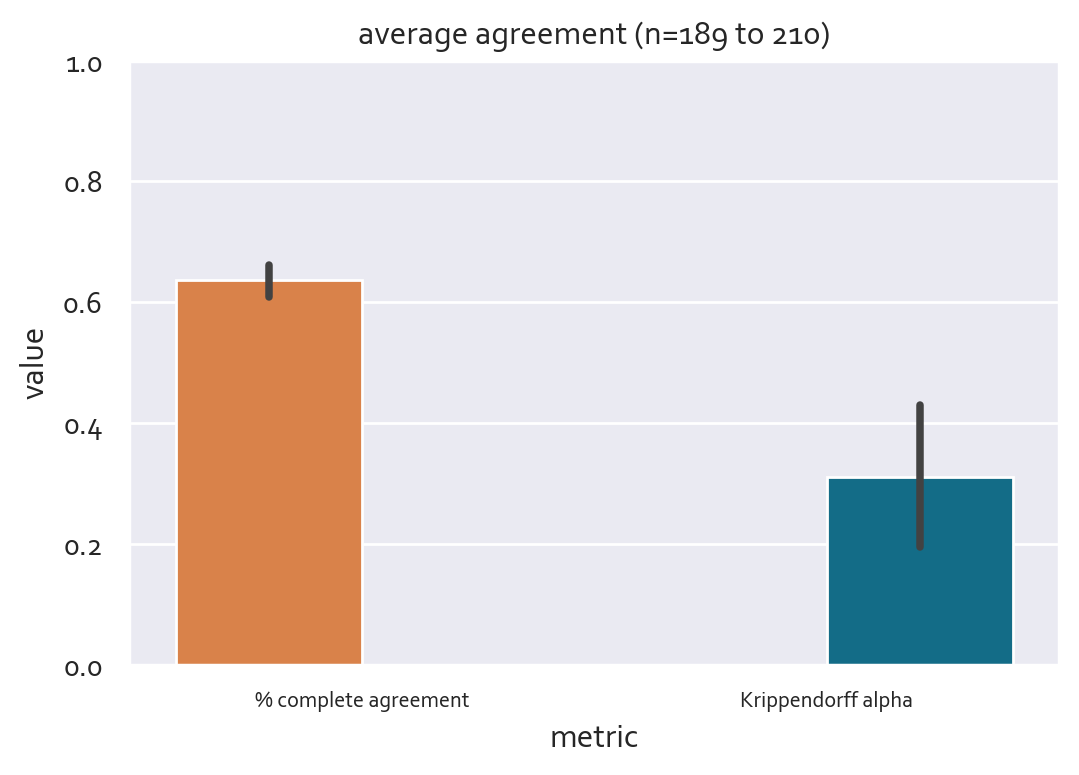

In [10]:
plot_metrics(ira, no_labels=True, legend=False, title="average agreement")

<AxesSubplot:title={'center':'agreement per label category (n=189 to 210)'}, xlabel='label', ylabel='value'>

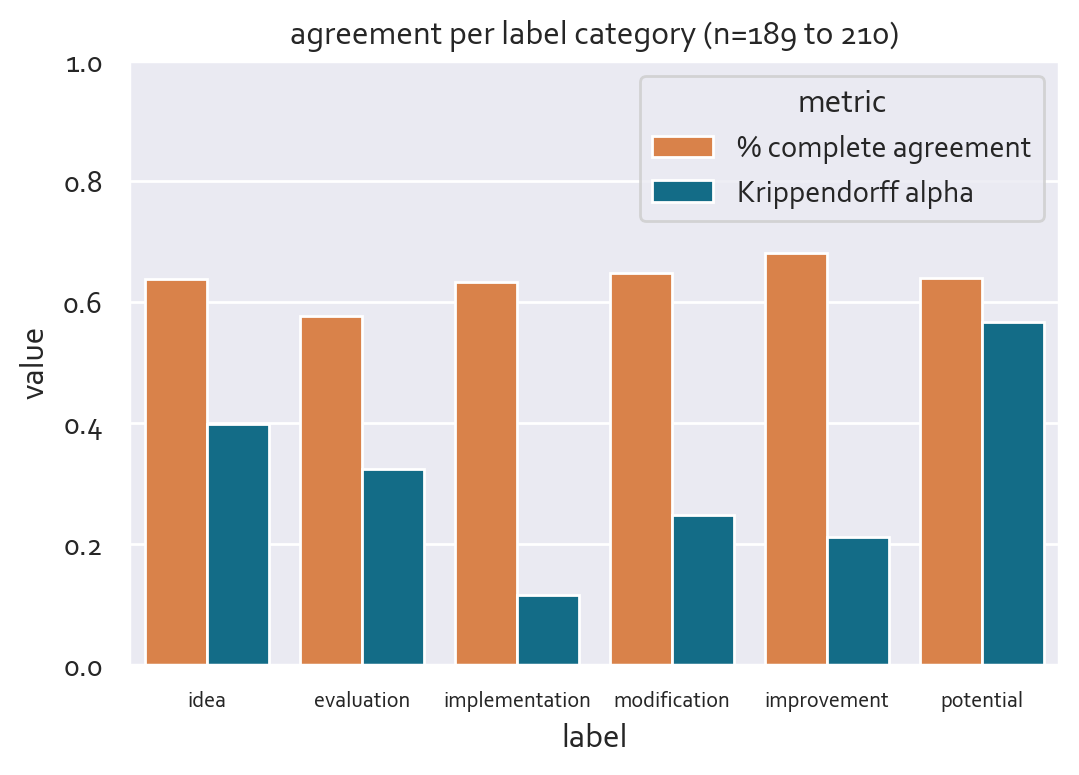

In [11]:
plot_metrics(ira, title="agreement per label category")

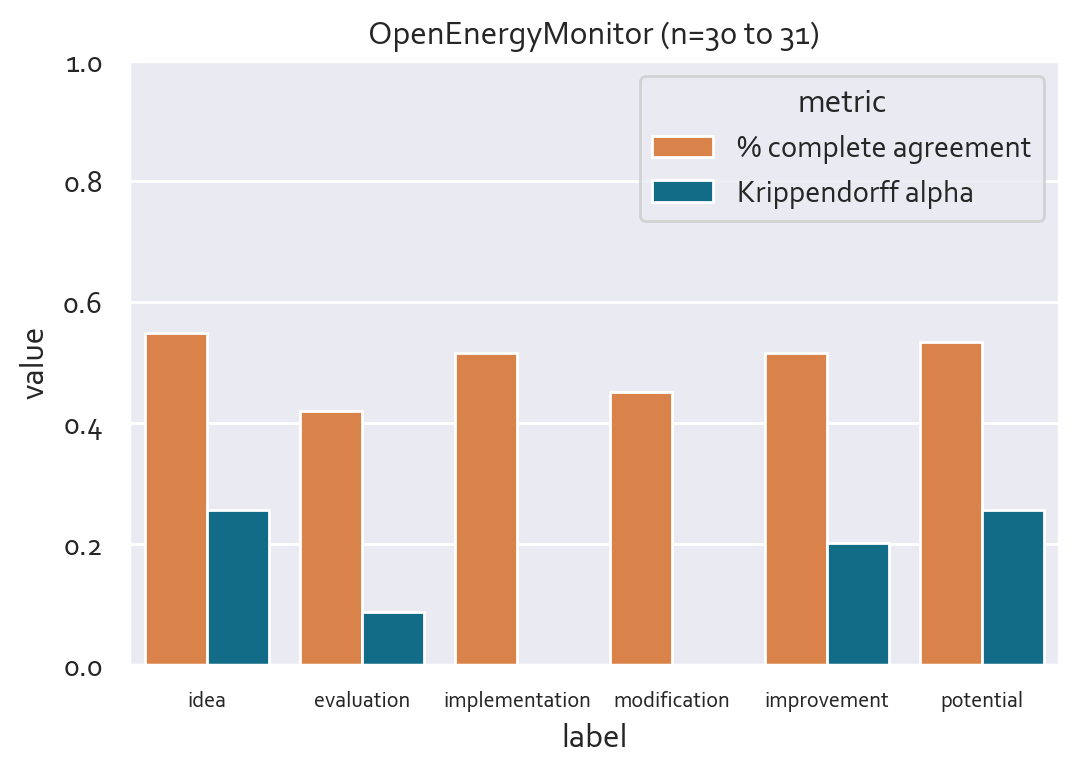

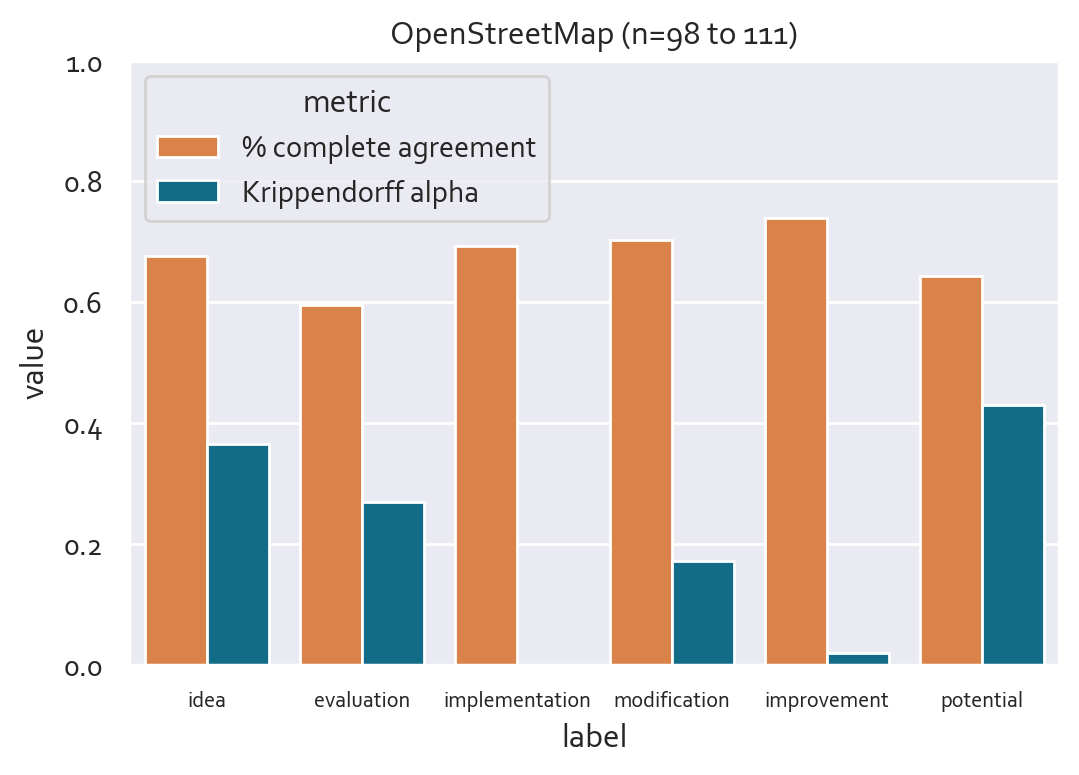

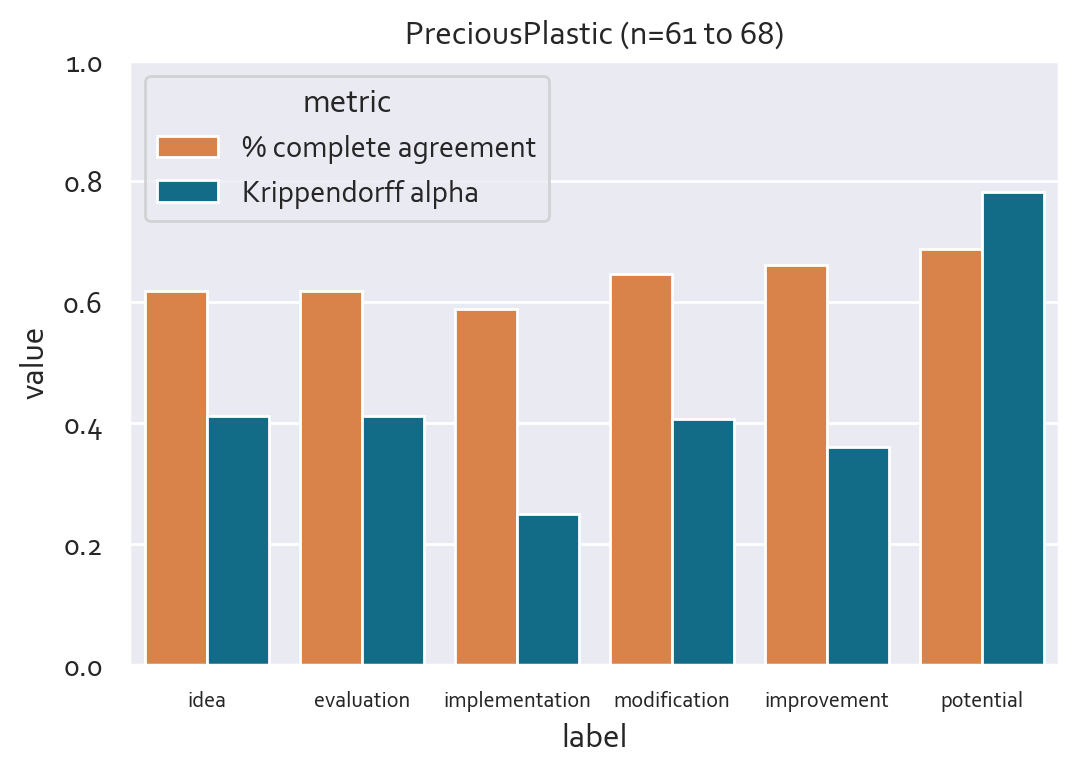

In [12]:
communities = label_stats.labels.data.community_name.unique().tolist()
for c in communities:
    label_stats.labels.set_filter(f'community_name == "{c}"')
    ira_c = label_stats.interrater_agreement()
    plot_metrics(ira_c, title=c)
    plt.show()

label_stats.labels.set_filter(None)

In [13]:
communities = label_stats.labels.data.community_name.unique().tolist()
iras = []
for c in communities:
    label_stats.labels.set_filter(f'community_name == "{c}"')
    ira_c = label_stats.interrater_agreement()
    ira_c['community'] = c
    iras.append(ira_c)

label_stats.labels.set_filter(None)
iras = pd.concat(iras)

<AxesSubplot:title={'center':'by community'}, xlabel='metric', ylabel='value'>

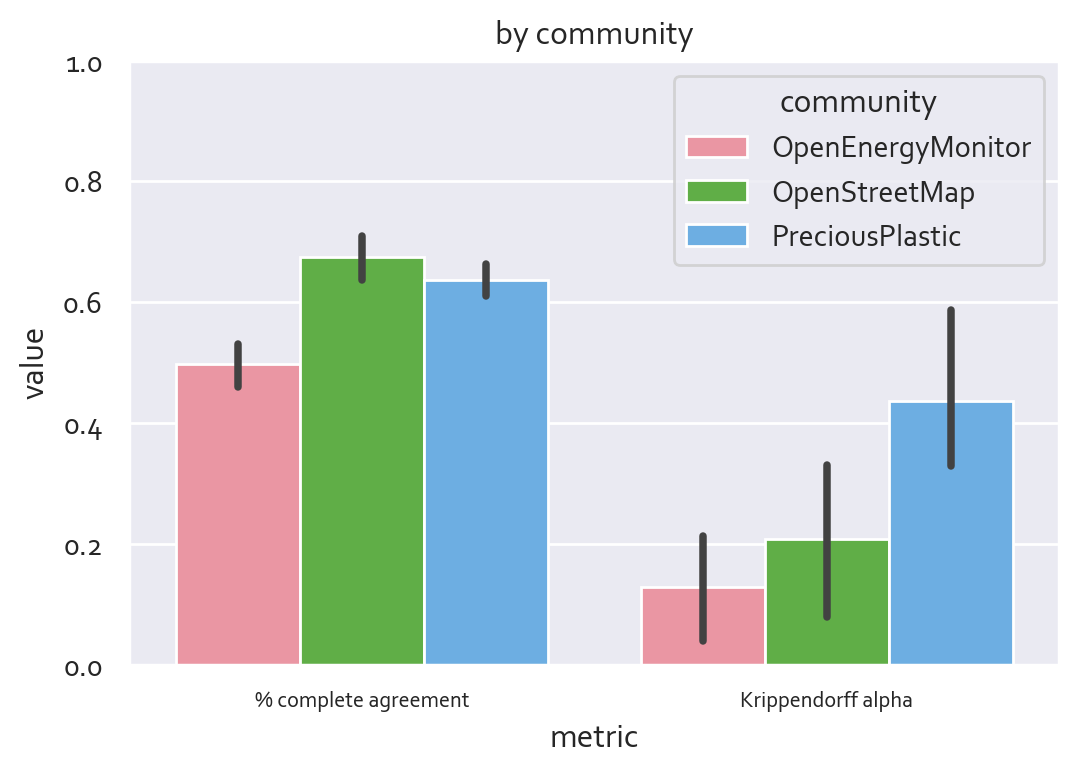

In [14]:
plot_metrics(iras, no_labels=True, metrics=['% complete agreement', 'Krippendorff alpha'], by_community=True, show_n=False, title="by community")